In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from sklearn.model_selection import train_test_split

# 데이터 전처리

In [12]:
# 데이터셋 로드 및 전처리
transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_unlabeled = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Baseline과 SimCLR에 서로 다른 transform을 적용하기 위해 labeled data를 위한 transform과 unlabeled data를 위한 transform을 따로 정의했다.

In [13]:
# transform을 각각 다르게 적용하기 위한 Custom Subset
class CustomSubset(Dataset):
    def __init__(self, dataset, indices, transform1=None, transform2=None):
        self.dataset = dataset
        self.indices = indices
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]

        # 각 이미지에 대해 서로 다른 두 가지 변환을 적용
        if self.transform1:
            img1 = self.transform1(img)
        if self.transform2:
            img2 = self.transform2(img)

        # 두 개의 augmentation된 이미지를 반환
        if self.transform2 != None:
            return img1, img2  # img1은 첫 번째 augmentation, img2는 두 번째 augmentation
        else:
            return img1, label

    def __len__(self):
        return len(self.indices)


# CIFAR100의 클래스별 10% 샘플링
def stratified_sampling(dataset, labeled_ratio=0.1):
    labels = np.array(dataset.targets)  # CIFAR-100의 정답 라벨
    train_indices, _ = train_test_split(
        np.arange(len(dataset)), stratify=labels, train_size=labeled_ratio, random_state=42
    )
    return train_indices

def get_cifar100_dataloaders(batch_size=128, labeled_ratio=0.1):
    dataset = datasets.CIFAR100(root='./data', train=True, download=True)
    test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_labeled)

    # 클래스별 10% 샘플링 적용
    labeled_indices = stratified_sampling(dataset, labeled_ratio)
    unlabeled_indices = np.setdiff1d(np.arange(len(dataset)), labeled_indices)

    labeled_dataset = CustomSubset(dataset, labeled_indices, transform_labeled)
    unlabeled_dataset = CustomSubset(dataset, unlabeled_indices, transform_unlabeled, transform_unlabeled)

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader


클래스별로 10%는 labeled data로 사용하고 나머지는 unlabeled data로 사용하기 위해 stratified_sampling를 만들어 labeled dataset과 unlabeled dataset으로 나눴다.

transform을 각각 다르게 적용하기 위해 CustomSubset을 만들어 labeled data에는 기존에 사용하던 transform을, unlabeled data에는 SimCLR에서 사용한 transform을 적용하였다. 또한 SimCLR에는 각 이미지를 두 가지의 augmentation을 적용하도록 코드를 구성했다.

# ResNet18

In [14]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                            nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(planes)
                            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [15]:
class ResNet(nn.Module):
    def __init__(self, num_classes, block=BasicBlock, num_blocks=[2, 2, 2, 2]):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


# SimCLR

In [16]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim):
        super(SimCLR, self).__init__()

        self.convnet = ResNet(100)

        # 마지막 fc 레이어 수정
        in_features = self.convnet.linear.in_features  # 기본 ResNet18의 fc 입력 크기 (512)

        self.convnet.linear = nn.Sequential(
            nn.Linear(in_features, 4 * hidden_dim),  # 4*hidden_dim으로 변환
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # 최종 출력은 hidden_dim 크기
        )

    def forward(self, x):
        # 수정된 ResNet18을 통해 입력을 처리
        x = self.convnet(x)
        return x

논문의 SimCLR에서는 pretrain된 모델을 가지고 대조 학습을 진행하였지만 10%의 labeled data로 학습시킨 ResNet18과 비교하기 위해 학습되지 않은 ResNet18을 사용하여 대조학습을 진행하였다.


In [17]:
def train_supervised(model, dataloader, epochs=50, lr=0.01, device="cuda" if torch.cuda.is_available() else "cpu"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.train()

    losses = []

    for epoch in range(epochs):
        epoch_loss = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return model, losses


In [ ]:
def pretrain_simclr(model, dataloader, epochs=100, lr=0.001, tau=0.07, device="cuda" if torch.cuda.is_available() else "cpu"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    model.train()

    losses = []

    for epoch in range(epochs):
        epoch_loss = 0

        for images1, images2 in dataloader:
            images1, images2 = images1.to(device), images2.to(device)
            optimizer.zero_grad()

            z1 = model(images1)
            z2 = model(images2)

            z1 = F.normalize(z1, dim=1)
            z2 = F.normalize(z2, dim=1)

            features = torch.cat([z1, z2], dim=0)  # (2N, D)

            # Compute cosine similarity
            cos_sim = F.cosine_similarity(features[:, None, :], features[None, :, :], dim=-1)

            # Mask out cosine similarity to itself
            self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=device)
            cos_sim.masked_fill_(self_mask, -9e15)

            # Find positive example -> batch_size//2 away from the original example
            pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

            # InfoNCE Loss
            cos_sim = cos_sim / tau
            nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
            loss = nll.mean()

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return model, losses


SimCLR에서는 InfoNCE Loss를 사용한다. 따라서 동일한 이미지에서 나온 augmentation된 두 이미지는 positive pair로, 배치 내에 있는 다른 이미지에서 나온 이미지들은 negative pair로 사용하도록 코드를 구성하였다.

cosine similarity를 구하고 자기 자신은 유사도를 계산하지 않도록 하기위해 mask를 씌우고 mask에 -9e15를 넣어주었다.

또한 동일한 이미지에서 나온 두 이미지는 positive pair로 만들어 주기 위해 roll을 사용하였다.

이렇게 만들어진 cos_sim과 pos_mask를 사용하여 InfoNCE Loss를 구했다.

In [18]:
# 평가 함수에서 데이터도 device로 이동
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # 데이터도 GPU로 이동
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

Files already downloaded and verified
Files already downloaded and verified


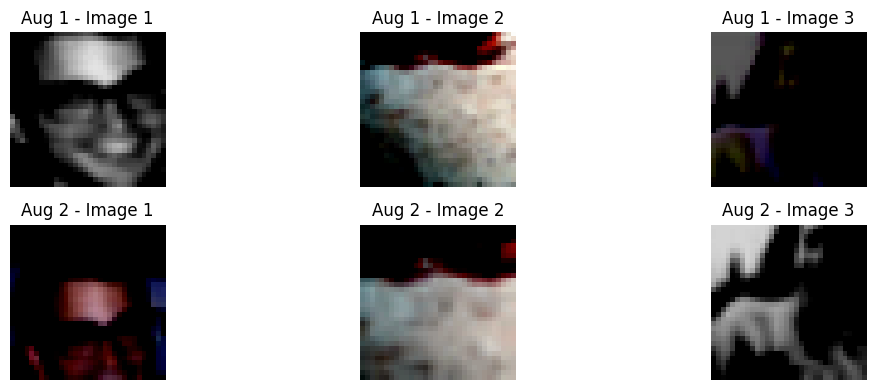

In [22]:
# 이미지들을 그리드 형식으로 시각화
def show_images(images1, images2, num_images=3):
    images1 = images1.cpu().numpy().transpose(0, 2, 3, 1)
    images2 = images2.cpu().numpy().transpose(0, 2, 3, 1)

    plt.figure(figsize=(12, 4))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images1[i])
        plt.title(f"Aug 1 - Image {i+1}")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(images2[i])
        plt.title(f"Aug 2 - Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_batch(dataloader, num_images=3):

    images1, images2 = next(iter(dataloader))

    # 이미지 시각화
    show_images(images1, images2, num_images)


labeled_loader, unlabeled_loader, test_loader= get_cifar100_dataloaders()
visualize_batch(unlabeled_loader, num_images=3)


In [23]:
print("Training Baseline Model...")
baseline_model = ResNet(100)
baseline_model, baseline_losses = train_supervised(baseline_model, labeled_loader)

Training Baseline Model...
Epoch [10/50], Loss: 3.9071
Epoch [20/50], Loss: 3.0394
Epoch [30/50], Loss: 1.2077
Epoch [40/50], Loss: 0.2862
Epoch [50/50], Loss: 0.2101


In [24]:
print("Pretraining with SimCLR...")
simclr_model = SimCLR(hidden_dim=128)
simclr_model, simclr_losses = pretrain_simclr(simclr_model, unlabeled_loader)

Pretraining with SimCLR...
Epoch [1/100], Loss: 4.0865
Epoch [2/100], Loss: 2.8191
Epoch [3/100], Loss: 2.3291
Epoch [4/100], Loss: 2.0344
Epoch [5/100], Loss: 1.8221
Epoch [6/100], Loss: 1.7060
Epoch [7/100], Loss: 1.5760
Epoch [8/100], Loss: 1.5173
Epoch [9/100], Loss: 1.4594
Epoch [10/100], Loss: 1.4020
Epoch [11/100], Loss: 1.3690
Epoch [12/100], Loss: 1.3204
Epoch [13/100], Loss: 1.2751
Epoch [14/100], Loss: 1.2578
Epoch [15/100], Loss: 1.2533
Epoch [16/100], Loss: 1.2191
Epoch [17/100], Loss: 1.1861
Epoch [18/100], Loss: 1.1734
Epoch [19/100], Loss: 1.1585
Epoch [20/100], Loss: 1.1314
Epoch [21/100], Loss: 1.0933
Epoch [22/100], Loss: 1.0781
Epoch [23/100], Loss: 1.0490
Epoch [24/100], Loss: 1.0384
Epoch [25/100], Loss: 1.0093
Epoch [26/100], Loss: 1.0031
Epoch [27/100], Loss: 0.9691
Epoch [28/100], Loss: 0.9539
Epoch [29/100], Loss: 0.9355
Epoch [30/100], Loss: 0.9228
Epoch [31/100], Loss: 0.9172
Epoch [32/100], Loss: 0.9035
Epoch [33/100], Loss: 0.8944
Epoch [34/100], Loss: 0.8

In [25]:
print("Fine-tuning after SimCLR...")

# Fine-tuning할 때는 SimCLR 모델에서 backbone을 가져와서 fc 레이어를 수정합니다.
fine_tuned_backbone = simclr_model.convnet

# ResNet18의 마지막 fc 레이어를 100 클래스를 출력하도록 수정
fine_tuned_backbone.linear = nn.Linear(512, 100)

# 이제 Fine-tuning을 진행합니다.
fine_tuned_model, fine_tuned_losses = train_supervised(fine_tuned_backbone, labeled_loader, epochs=50, lr=0.01)

print("Training Completed!")


Fine-tuning after SimCLR...
Epoch [10/50], Loss: 0.5811
Epoch [20/50], Loss: 0.2060
Epoch [30/50], Loss: 0.2030
Epoch [40/50], Loss: 0.0823
Epoch [50/50], Loss: 0.1939
Training Completed!


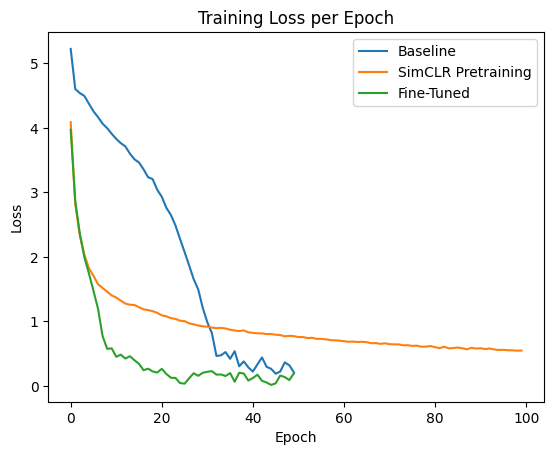

In [26]:
# 그래프 시각화
plt.plot(baseline_losses, label='Baseline')
plt.plot(simclr_losses, label='SimCLR Pretraining')
plt.plot(fine_tuned_losses, label='Fine-Tuned')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss per Epoch')
plt.show()

In [27]:
# 모델을 device로 이동
baseline_model.to(device)
fine_tuned_model.to(device)

baseline_eval = evaluate(baseline_model, test_loader)
simclr_eval = evaluate(fine_tuned_model, test_loader)

print(f"Baseline Test Accuracy: {baseline_eval * 100:.2f}%")
print(f"SimCLR Test Accuracy: {simclr_eval * 100:.2f}%")


Baseline Test Accuracy: 22.14%
SimCLR Test Accuracy: 30.70%


Baseline 모델과 SimCLR 모델의 train loss는 각각 0.2101과 0.1939로 비슷하게 나왔지만, test accuracy에서는 꽤 큰 차이가 났다. 이 결과는 SimCLR을 사용한 모델이 더 잘 일반화된 성능을 보였다는 것을 나타낸다.

train loss가 비슷한 이유는 두 모델이 모두 학습 데이터에 대해 잘 맞춰졌기 때문이다. Baseline 모델은 전통적인 supervised learning 방식으로 학습됐고, SimCLR은 contrastive learning 방식을 사용했다. 하지만 train loss만 보면 두 모델의 성능 차이는 크지 않다. 이는 두 모델 모두 학습 데이터에 대해서는 잘 학습됐음을 의미한다.

하지만 test accuracy에서는 차이가 났다. Baseline 모델은 test 데이터에서 정확도가 낮았고, SimCLR 모델은 더 높은 정확도를 기록했다. 이는 SimCLR 모델이 더 잘 일반화되었기 때문이다.

SimCLR이 더 잘 일반화되는 이유는 contrastive learning 방식을 사용했기 때문이다. SimCLR은 대규모의 unlabeled 데이터에서 유용한 특징을 학습할 수 있어, test 데이터에서도 더 나은 성능을 보일 수 있었다. 반면, Baseline 모델은 labeled 데이터에 의존하여 학습되기 때문에 test 데이터에서 overfitting 현상이 발생할 가능성이 있었다.

SimCLR은 positive pair와 negative pair를 비교하면서 이미지를 잘 구별할 수 있는 특징을 학습한다. 이로 인해 모델이 더 다양한 상황에서 잘 작동할 수 있게 됐다. 그래서 test accuracy에서 SimCLR이 더 높은 성능을 보인 것이다.

결론적으로, SimCLR이 더 좋은 성능을 보였다는 것은 모델이 학습 데이터뿐만 아니라 새로운 데이터에 대해서도 더 잘 일반화된 특징을 학습했기 때문이었다.